# Dogs vs Cats

In [1]:
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import os

## Load the data

In [3]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
import kaggle
kaggle.api.authenticate()

Saving kaggle.json to kaggle.json


In [5]:
! kaggle competitions download -c dogs-vs-cats
! unzip -q train.zip
# ! unzip -q test1.zip

Reading the images, converting to grayscale, and resizing to a standard size.  
Loading the data as two datasets, one will be 32x32 images, and the other 64x64.

In [6]:
train_path = '/content/train'
train_folder = os.listdir(train_path)
train_data = np.ndarray(shape=(len(train_folder), 64*64), dtype=float)
train_data_32 = np.ndarray(shape=(len(train_folder), 32*32), dtype=float)
train_labels = np.ndarray(shape=(len(train_folder),), dtype=int)
index2imgpath = dict()
for i, img_name in enumerate(train_folder):
  with Image.open(os.path.join(train_path, img_name)) as img:
    train_labels[i] = img_name.split('.')[0].lower() == 'cat'
    train_data[i] = np.array(ImageOps.grayscale(img.resize((64, 64)).getdata()))
    train_data_32[i] = np.array(ImageOps.grayscale(img.resize((32, 32)).getdata()))
    index2imgpath[i] = os.path.join(train_path, img_name)

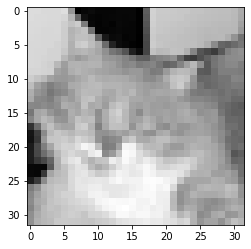

In [4]:
# Print the fisrt 32x32 image
plt.imshow(train_data_32[0].reshape(32, 32), cmap='gray')

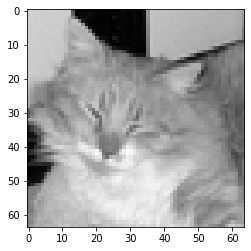

In [5]:
# Print the fisrt 64x64 image
plt.imshow(train_data[0].reshape(64, 64), cmap='gray')

## Data preprocesing

In [10]:
# Normalize the data
train_data_normalized = train_data / 255.
train_data_32_normalized = train_data_32 / 255.

## Fitting the models

For this task I'll use XGBoost classifier

### 32x32

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Split the data into training and test set
X_train_32, X_test_32, y_train, y_test = train_test_split(train_data_32_normalized, train_labels, random_state=42)

In [13]:
import xgboost as xgb

In [14]:
# Fit the model
model_1 = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_estimators=500, random_state=42)
model_1.fit(X_train_32, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [15]:
# Training score
model_1.score(X_train_32, y_train)

0.8439466666666666

In [16]:
# Test score
model_1.score(X_test_32, y_test)

0.66912

### 64x64

In [12]:
# Split the data into training and test set
X_train_64, X_test_64, y_train, y_test = train_test_split(train_data, train_labels, random_state=42)

In [14]:
# Fit the model
model_2 = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_estimators=500, random_state=42)
model_2.fit(X_train_64, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [15]:
# Training score
model_2.score(X_train_64, y_train)

0.8666666666666667

In [16]:
# Test score
model_2.score(X_test_64, y_test)

0.67568

Looks like using larger images is slightly better, but it also increases the training time significantly.

### Using opencv to create new features by using edge detection
I will only do that for the larger images

In [18]:
import cv2

In [136]:
# First we need to add blur to the images
train_data_blur = np.array([cv2.GaussianBlur(img, (3,3), 0) for img in train_data.reshape(25000, 64, 64)])

In [137]:
# Use the blurred images to calculate the edges
train_data_edges = np.array([cv2.Canny(img.astype(np.uint8), threshold1=150, threshold2=200) for img in train_data_blur])

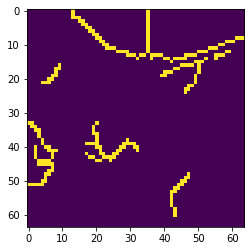

In [138]:
# Show the edges for the first image
plt.imshow(train_data_edges[0])

In [154]:
# Combine the images with the edges into a single dataset
X_train_edges, X_test_edges, y_train, y_test = train_test_split(np.concatenate([train_data, train_data_edges.reshape(25000, 64*64)], 1), train_labels, random_state=42)

In [155]:
# Fit the model
model_4 = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_estimators=200, random_state=42, max_depth=5)
model_4.fit(X_train_edges, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [156]:
model_4.score(X_test_edges, y_test)

0.6712

Using the edge detection didn't seem to improve the accuracy.  
This could be due to the complexity and size of the data.  
Using neural networks for this task would probably result in better predictions.